## Przewidywanie trendu kursu giełdowego

## Nie jest przewidywana dokładna cena, a jedynie próg zmian:
### -Cena bardzo rośnie
### -Cena trochę rośnie
### -Cena trochę maleje
### -Cena bardzo maleje
## Na wejściu: ceny dolara, funta i euro przez N dni
## Na wyjściu: etykieta reprezentująca zmianę ceny WIGu w dniu następnym

## Początkowa obróbka danych

In [1]:
def selectTimeRange(df, start_date, end_date):
    from datetime import datetime as dt
    
    start_date = dt.strptime(start_date, '%d.%m.%Y')
    end_date = dt.strptime(end_date, '%d.%m.%Y')
    
    low_idx = 0
    while dt.strptime( df['dates'][low_idx], '%d.%m.%Y') <= start_date:
        low_idx = low_idx + 1
    
    up_idx = df.index.stop - 1
    while dt.strptime( df['dates'][up_idx], '%d.%m.%Y') >= end_date:
        up_idx = up_idx - 1
        
    df = df[ low_idx:up_idx ]
    df.reindex( [ i for i in range(len(df)) ] )
    return df 

# Wczytaj dane i ustaw przedział czasowy
import pandas as pd

df_raw = pd.read_csv("data.csv")
# df = selectTimeRange(df_raw, '01.01.2018', '31.12.2023')
df = df_raw.copy()
df.head()

,dates,usd,pound,wig,euro
0,31.01.2013,3.0814,4.8857,46840.15,4.1944
1,01.02.2013,3.0498,4.7882,46945.58,4.1630
2,04.02.2013,3.0905,4.8666,46556.55,4.1761
3,05.02.2013,3.0747,4.8168,46674.78,4.1764
4,06.02.2013,3.0875,4.8347,46149.14,4.1752


## Pomocniczy dataframe ze względnymi zmianami

In [2]:
def absoluteChange( prizes ):
    result = [None]*( len(prizes) )
    result[0] = 0
    for i in range( 1, len(prizes) ):
        result[i] = prizes[i] - prizes[i-1]
    return result

def relativeChange( prizes ):
    result = [None]*( len(prizes) )
    result[0] = 0
    for i in range( 1, len(prizes) ):
        result[i] = prizes[i] / prizes[i-1]
    return result

def relativeAbsoluteChange( prizes ):
    result = [None]*( len(prizes) )
    result[0] = 0
    for i in range( 1, len(prizes) ):
        result[i] = prizes[i] / prizes[i-1] - 1
    return result

def dataChange( df, mode ):
    import pandas as pd
    
    cols = list( df.columns)
    temp_dict = { c:None for c in cols }
    for c in cols[1:]:
        if mode == 'absolute':
            temp_dict[c] = absoluteChange( df[c] )
        elif mode == 'relative':
            temp_dict[c] = relativeChange( df[c] )
        elif mode == 'relabs':
            temp_dict[c] = relativeAbsoluteChange( df[c] )
        else:
            return None
    temp_dict[ cols[0] ] = df[ cols[0] ]
    df_dt = pd.DataFrame(temp_dict)
    return df_dt

df_dt = dataChange( df, 'relabs' )
df_dt.head()

,dates,usd,pound,wig,euro
0,31.01.2013,0.000000,0.000000,0.000000,0.000000
1,01.02.2013,-0.010255,-0.019956,0.002251,-0.007486
2,04.02.2013,0.013345,0.016374,-0.008287,0.003147
3,05.02.2013,-0.005112,-0.010233,0.002539,0.000072
4,06.02.2013,0.004163,0.003716,-0.011262,-0.000287


## Bez uśredniania i usuwania outlierów

In [3]:
df_dt_cleaned = df_dt.copy()

## Policzenie przedziałów zmian - utworzenie etykiet:
### q<...;-mean-std> - kurs bardzo maleje
### q<-mean-std;0> - kurs trochę maleje
### q<0;-mean+std> - kurs trochę rośnie
### q< -mean+std;...> - kurs bardzo rośnie
### mean, std - znormalizowane, tak że mean wynosi 0

In [4]:
# normalizacja WIGu
temp = df_dt_cleaned['wig'].mean()
df_dt_cleaned['wig'] = df_dt_cleaned['wig'] - temp

In [5]:
import numpy as np

std = np.std(df_dt_cleaned[1:]['wig'])
boundaries = [ - std, 0,  std ]
print(f"przedział: {boundaries}")

def getLabel(value):
    if value < boundaries[0]:
        return 0
    elif value >= boundaries[0] and value < boundaries[1]:
        return 1
    elif value >= boundaries[1] and value < boundaries[2]:
        return 2
    elif value >= boundaries[2]:
        return 3
    
df_dt_cleaned['label'] = [ getLabel(v) for v in df_dt_cleaned['wig'][:]]

przedział: [-0.011676920499066322, 0, 0.011676920499066322]


## Utworzenie zbioru treningowego i testowego

In [6]:
# Odłożenie części danych do późniejszej predykcji
pred_len = 50

In [7]:
# Funkcja zależna od rodzju danych!!!
# sample_length - ilość wartości w jednej próbce treningowej
# shuffle - przemieszaj kolejność próbek treningowych
def prepareData(raw_data, sample_length, shuffle=False):
    x_cols = ['usd','pound','euro']
#     x_cols=['wig']
    y_cols = ['label']
    X=[None]*(len(raw_data)-sample_length)
    y=[None]*(len(raw_data)-sample_length) 
    
    idx = [ i for i in range(len(raw_data)-sample_length)]
    if shuffle == True:
        import numpy as np
        idx = np.array(idx, dtype="object")
        np.random.shuffle(idx)
    
    for i in range(sample_length, len(raw_data)):
        xvals = []
        for col in x_cols:
            xvals.append( [ 100*x for x in raw_data[col][i-sample_length:i] ] )
        X[idx[i-sample_length]] = xvals
        y[idx[i-sample_length]] = int( raw_data[y_cols].iloc[i].values[0] )
    
    
    return {'X':X, 'y':y}

sample_length = 250
processed_data = prepareData(df_dt_cleaned[1:-pred_len], sample_length, shuffle=True)

In [8]:
def splitDataToTrainAndTest( processed_data, trainingProportion):
    # trainingPorportion - stosunek podziału danych treningowych do testowych (0;1)
    
    data_len = len(processed_data['X'])
    
    X_train = processed_data['X'][:int(data_len*trainingProportion)]
    y_train = processed_data['y'][:int(data_len*trainingProportion)]
    X_val = processed_data['X'][int(data_len*trainingProportion):]
    y_val = processed_data['y'][int(data_len*trainingProportion):]
    
    return X_train, y_train, X_val, y_val

trainingProportion = 0.6
X_train, y_train, X_val, y_val = splitDataToTrainAndTest(processed_data, trainingProportion)

## Utworzenie modelu i trening

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam 

n_input = 3
n_features = sample_length

model_stock = Sequential()

model_stock.add(InputLayer((n_input, n_features)))

model_stock.add(Dense(400, activation="relu"))
model_stock.add(Dropout(0.1))
model_stock.add(Flatten())

model_stock.add(Dense(1, activation="linear"))

model_stock.summary()

In [10]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 4 )
model_stock.compile(loss = MeanSquaredError(),
    optimizer=Adam(
#         learning_rate=0.0005
    ),
    metrics=BinaryCrossentropy()),
history = model_stock.fit(
    X_train, y_train,
    validation_data= (X_val, y_val),
    epochs = 100,
    callbacks=[early_stop],
)


Epoch 1/100
44/44 [==============================] - 2s 30ms/step - loss: 1.2461 - binary_crossentropy: -5.4994 - val_loss: 1.0046 - val_binary_crossentropy: -6.4751
Epoch 2/100
44/44 [==============================] - 0s 4ms/step - loss: 0.5202 - binary_crossentropy: -8.5342 - val_loss: 0.9859 - val_binary_crossentropy: -6.1597
Epoch 3/100
44/44 [==============================] - 0s 4ms/step - loss: 0.3141 - binary_crossentropy: -9.1423 - val_loss: 0.9931 - val_binary_crossentropy: -6.0252
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 0.1959 - binary_crossentropy: -9.4528 - val_loss: 1.0159 - val_binary_crossentropy: -5.6769
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 0.1150 - binary_crossentropy: -9.6433 - val_loss: 1.0405 - val_binary_crossentropy: -5.9928
Epoch 6/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0949 - binary_crossentropy: -9.6447 - val_loss: 1.0458 - val_binary_crossentropy: -5.7857


<Axes: >

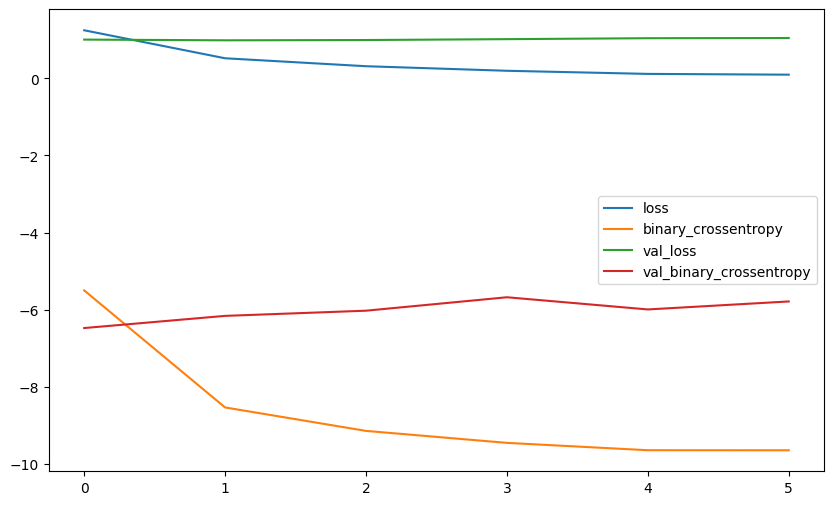

In [11]:
import pandas as pd

losses_df = pd.DataFrame(model_stock.history.history)
losses_df.plot(figsize = (10,6))

## Predykcja wyniku i wyświetlenie macierzy pomyłek

44/44 [==============================] - 0s 1ms/step
Accuracy - training: 0.975609756097561
30/30 [==============================] - 0s 885us/step
Accuracy - validation: 0.3634408602150538


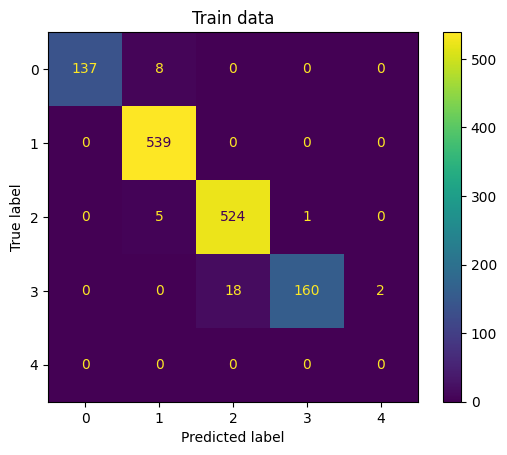

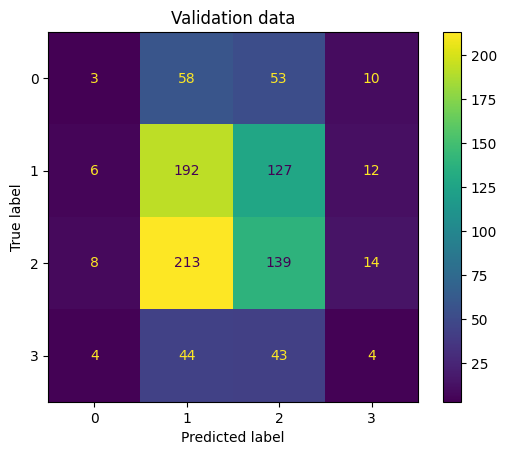

In [12]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    
# Wynik na danych treningowych
y_pred = model_stock.predict(X_train).flatten()
y_pred = [ int(np.round(y)) for y in y_pred ]

cm = confusion_matrix(y_train, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Train data")
print(f"Accuracy - training: {sum([ y_train[i] == y_pred[i] for i in range(len(y_train)) ])/len(y_train)}")

# Wynik na danych testowych
y_pred = model_stock.predict(X_val).flatten()
y_pred = [ int(np.round(y)) for y in y_pred ]

cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Validation data")
print(f"Accuracy - validation: {sum([ y_val[i] == y_pred[i] for i in range(len(y_val)) ])/len(y_val)}")

## Dokładność na nowych danych:

2/2 [==============================] - 0s 2ms/step
Accuracy - total: 0.36


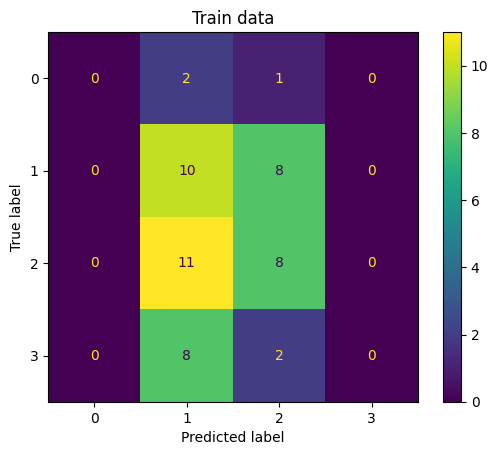

In [13]:
future_data = prepareData(df_dt_cleaned[-pred_len-sample_length:], sample_length, shuffle=False)
X_future = future_data['X']
y_future = future_data['y']

y_pred = model_stock.predict(X_future).flatten()
y_pred = [ int(np.round(y)) for y in y_pred ]

cm = confusion_matrix(y_future, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Train data")
print(f"Accuracy - total: {sum([ y_future[i] == y_pred[i] for i in range(len(y_future)) ])/len(y_future)}")